# KPI Metrics Visualization

We use key performance indicators, or KPIs, to measure the effectiveness of CI testing processes and understand how to improve them. These KPIs are calculated in notebooks and saved as different metrics. You can see a list of the available metrics and the notebooks that calculate them [here](https://github.com/aicoe-aiops/ocp-ci-analysis/tree/master/notebooks/data-sources/TestGrid/metrics).

Through this notebook, we want to provide a way for users to explore and visualize the available metrics. Although we plan on setting up external tools (such as Apache Superset) for visualization, we also want to provide the option to visualize KPIs in a Jupyter notebook native environment since that is where a lot of data science development happens.

In this notebook, we plot basic time series graphs for each of the KPI metrics aggregated across all TestGrid dashboards,jobs and tests to visualize how the KPI metric values change over time.

In [1]:
# Import required libraries
import os
from tqdm import tqdm
from collections import defaultdict
from dotenv import load_dotenv, find_dotenv

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from ipynb.fs.defs.metric_template import CephCommunication

load_dotenv(find_dotenv())
sns.set(rc={"figure.figsize": (15, 5)})

In [2]:
## Specify variables

## CEPH Bucket variables
## Create a .env file on your local with the correct configs
## Follow this example - https://github.com/aicoe-aiops/ocp-ci-analysis/blob/master/.env-example
s3_endpoint_url = os.getenv("S3_ENDPOINT")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")
s3_path = os.getenv("S3_PROJECT_KEY", "ai4ci/testgrid/metrics")

# Specify whether or not we are running this as a notebook or part of an automation pipeline.
AUTOMATION = os.getenv("IN_AUTOMATION")

## Ceph Connection
We will need to connect to Ceph to fetch all the KPI metric data.

In [3]:
## Connect to Ceph

# ceph connector
cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)

# bucket where the KPI metrics are stored
metrics_bucket = cc.s3_resource.Bucket(s3_bucket)

# get all objects (files) corresponding to all metrics
available_kpi_files = metrics_bucket.objects.filter(Prefix=s3_path)

## Get KPI Data

In [4]:
# extract the names of unique KPI metric files, and the KPIs available in them
kpis_in_kpifile = defaultdict(list)

for obj in tqdm(available_kpi_files):
    # split key into prefix "directory", metric name, and filename
    dir_name, metric_obj_name, file_name = obj.key.split("/")

    # update dictionary if key doesnt exist
    # NOTE: this assumes that the kpis recorded in a kpi filename doesnt change over time
    # e.g. if pass_fail_2021-6-21.csv had "pass", "fail", and "timestamp" columns, so will pass_fail_2021-6-22.csv
    if metric_obj_name not in kpis_in_kpifile:
        # read a sample file to see what kpis are contained in this file
        sample_file = cc.read_from_ceph(f"{dir_name}/{metric_obj_name}", file_name)

        # get these kpis names
        kpis = sample_file.columns.drop(
            ["timestamp", "tab", "job", "grid", "test"], errors="ignore"
        ).tolist()

        # update mapping of "filename": "kpi"
        kpis_in_kpifile[metric_obj_name] = kpis

124it [00:34,  3.62it/s]


In [5]:
kpis_in_kpifile

defaultdict(list,
            {'avg_correlation': ['average_number_of_correlated_failures'],
             'blocked_timed_out': ['test_blocked', 'test_timed_out'],
             'build_pass_failure': ['test_duration',
              'build_failure',
              'build_passing',
              'build_status'],
             'correlation': ['test_name', 'correlated_tests'],
             'number_of_flakes': ['test_duration', 'flake'],
             'pct_fixed_each_ts': ['pct_fixed'],
             'persistent_failures': ['consec_fail_rate',
              'mean_fail_len',
              'mean_time_to_fix',
              'pass_to_fail_rate',
              'fail_to_pass_rate'],
             'test_pass_failures': ['test_duration', 'failure', 'passing'],
             'time_to_test': ['test_duration']})

## Helper Function for Plotting

In [6]:
# plots a linear time series graph
def plot(date, vals, xlabel, ylabel, title):
    sns.lineplot(
        x=date,
        y=vals,
    )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

## Visualize KPIs
Now, let's start visualizing each of the KPIs.

### Blocked Timed Out
The `blocked_timed_out` KPI file consists of `test_blocked` and `test_timed_out` metric files which comprise of metric data like number of tests blocked. We will read each of these files and aggregate the metric values across all TestGrid dashboard, job and tests. We can then plot these aggregate metrics values.

In [7]:
blocked_timedout_files = metrics_bucket.objects.filter(
    Prefix="metrics/blocked_timed_out"
)

dates = []
blocked_vals_to_plot = []
blocked_percentage = []
timedout_vals_to_plot = []
timedout_percentage = []

for i in blocked_timedout_files:
    # split into project key and file "path"
    project_bucket, kpifile_key = i.key.split("/", maxsplit=1)

    # read parquet
    df = cc.read_from_ceph(project_bucket, kpifile_key)

    # get x and y values to plot for this date
    blocked_vals_to_plot.append(
        df.test_blocked.replace([np.inf, -np.inf], np.nan).sum(),
    )
    blocked_percentage.append(
        (df.test_blocked.replace([np.inf, -np.inf], np.nan).sum()) / (len(df)),
    )
    timedout_vals_to_plot.append(
        df.test_timed_out.replace([np.inf, -np.inf], np.nan).sum(),
    )
    timedout_percentage.append(
        (df.test_timed_out.replace([np.inf, -np.inf], np.nan).sum()) / (len(df)),
    )
    dates.append(
        kpifile_key.rsplit("/", maxsplit=1)[-1]
        .split("-", maxsplit=1)[-1]
        .split(".", maxsplit=1)[0]
    )

Let's plot the following metrics from the `blocked_timed_out` KPI file:

#### Number of blocked tests
This metric keeps track of the total number of blocked tests on TestGrid. Lets plot these values for each day.

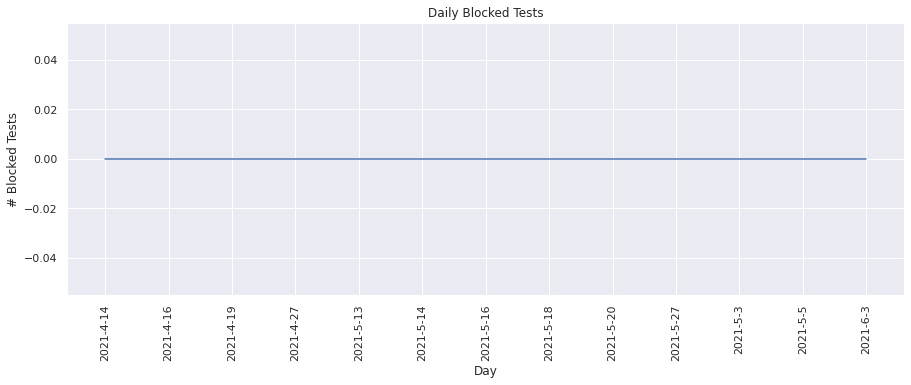

In [8]:
plot(dates, blocked_vals_to_plot, "Day", "# Blocked Tests", "Daily Blocked Tests")

#### Blocked tests percentage
This metric calculates the percentage of blocked tests on TestGrid. We can visualize the change in percentage over time.

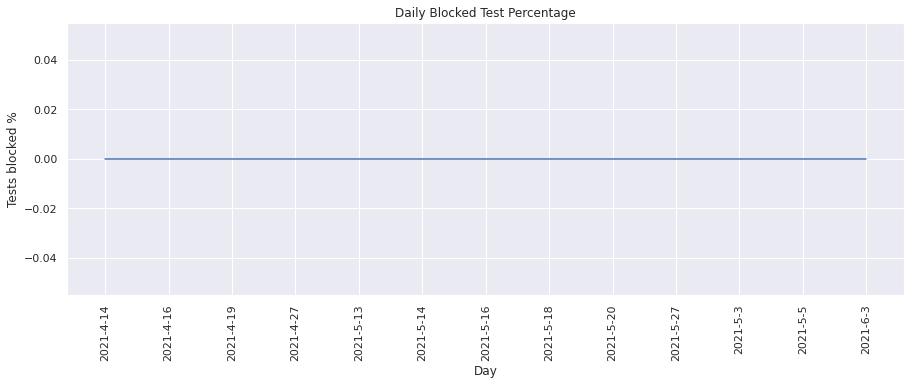

In [9]:
plot(
    dates, blocked_percentage, "Day", "Tests blocked %", "Daily Blocked Test Percentage"
)

#### Number of timed out tests
This metric keeps track of the total number of timed out tests on TestGrid. Lets plot these values for each day.

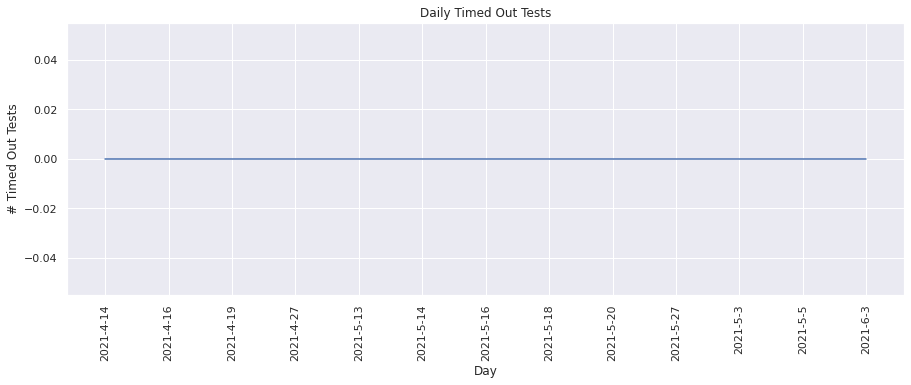

In [10]:
plot(dates, timedout_vals_to_plot, "Day", "# Timed Out Tests", "Daily Timed Out Tests")

#### Percentage of tests timed out
This metric calculates the percentage of timed out tests on TestGrid. We can visualize the change in percentage over time.

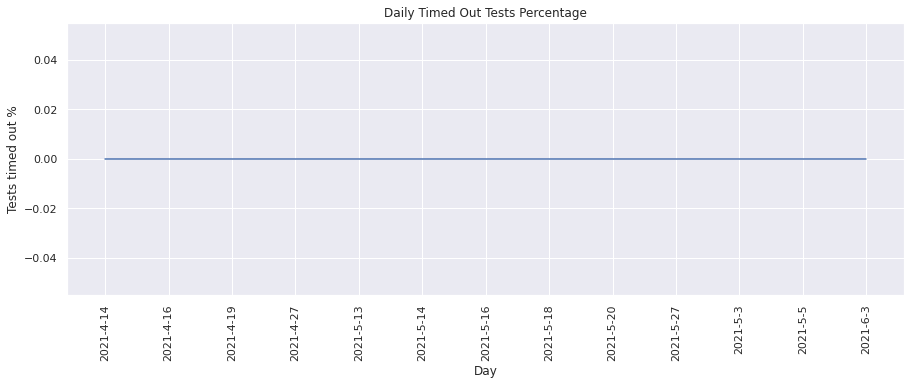

In [11]:
plot(
    dates,
    timedout_percentage,
    "Day",
    "Tests timed out %",
    "Daily Timed Out Tests Percentage",
)

From the above graphs, we see that there were no blocked tests or timed out tests found.

### Build Pass Failure
The `build_pass_failure` KPI file consists of `test_duration`, `build_failure`, `build_passing`, `build_status` metric files which comprise of metric data like number of builds passing, number of builds failing etc. We will read each of these files and aggregate the metric values across all TestGrid dashboard, job and tests. We can then plot these aggregate metrics values.

In [12]:
build_pass_failure_files = metrics_bucket.objects.filter(
    Prefix="metrics/build_pass_failure"
)

dates = []
build_pass_vals_to_plot = []
build_pass_percentage = []
build_fail_vals_to_plot = []
build_fail_percentage = []

for i in build_pass_failure_files:
    # split into project key and file "path"
    project_bucket, kpifile_key = i.key.split("/", maxsplit=1)

    # read parquet
    df = cc.read_from_ceph(project_bucket, kpifile_key)

    # get x and y values to plot for this date
    build_pass_vals_to_plot.append(
        df.build_passing.replace([np.inf, -np.inf], np.nan).sum(),
    )
    build_pass_percentage.append(
        (df.build_passing.replace([np.inf, -np.inf], np.nan).sum()) / (len(df)),
    )
    build_fail_vals_to_plot.append(
        df.build_failure.replace([np.inf, -np.inf], np.nan).sum(),
    )
    build_fail_percentage.append(
        (df.build_failure.replace([np.inf, -np.inf], np.nan).sum()) / (len(df)),
    )
    dates.append(
        kpifile_key.rsplit("/", maxsplit=1)[-1]
        .split("-", maxsplit=1)[-1]
        .split(".", maxsplit=1)[0]
    )

Let's plot the following metrics from the `build_pass_failure` KPI file:

#### Number of builds passed
This metric tracks the total number of builds that were passing. Lets plot these values for each day.

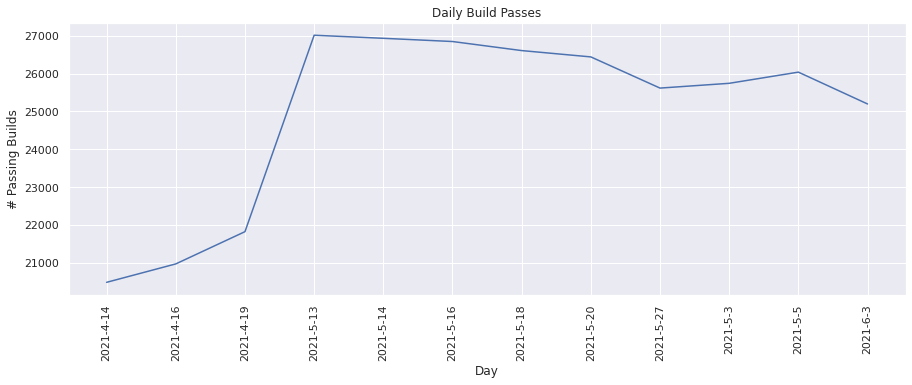

In [13]:
plot(dates, build_pass_vals_to_plot, "Day", "# Passing Builds", "Daily Build Passes")

#### Build pass percentage
This metric calculates the percentage of builds that were passing. We can visualize the change in percentage over time.

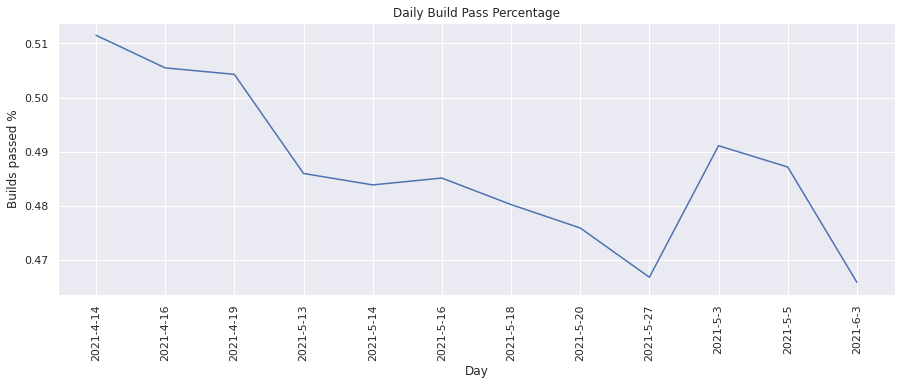

In [14]:
plot(
    dates,
    build_pass_percentage,
    "Day",
    "Builds passed %",
    "Daily Build Pass Percentage",
)

From the above graphs, we see that on an average about ~50% of builds pass.

#### Number of build failures
This metric tracks the total number of builds that were failing. Lets plot these values for each day.

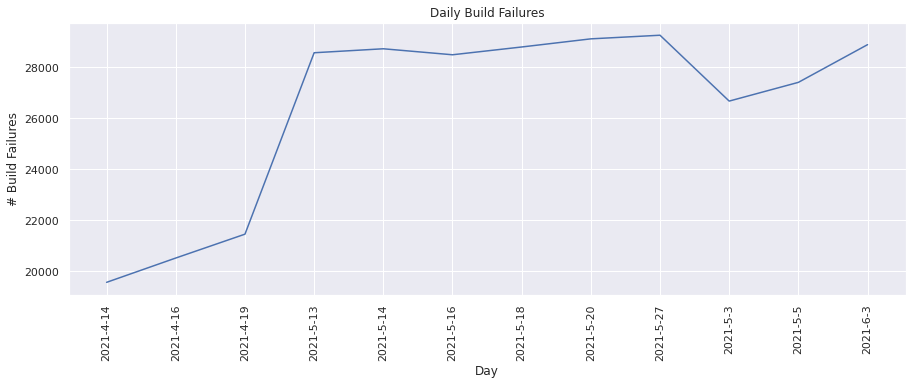

In [15]:
plot(dates, build_fail_vals_to_plot, "Day", "# Build Failures", "Daily Build Failures")

#### Build failure percentage
This metric calculates the percentage of builds that were failing. We can visualize the change in percentage over time.

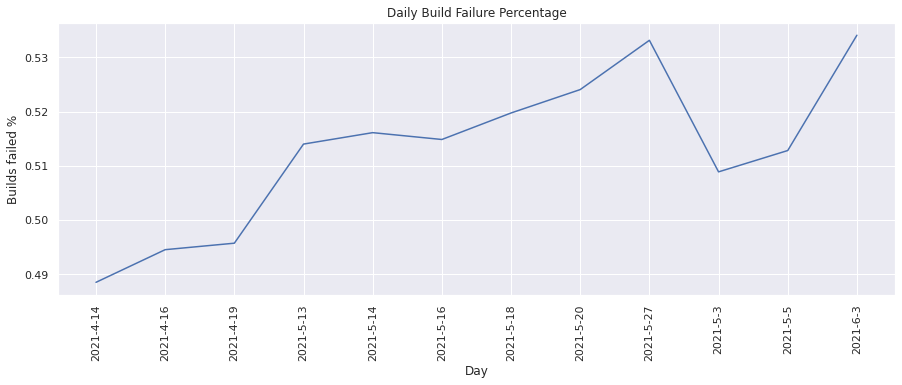

In [16]:
plot(
    dates,
    build_fail_percentage,
    "Day",
    "Builds failed %",
    "Daily Build Failure Percentage",
)

From the above graphs we see that on an average about ~50% of builds fail i.e there is a 50-50 chance for a build to either pass or fail.

### Number of Flakes
The `number_of_flakes` KPI file consists of `test_duration` and `flake` metric files which comprise of metric data like number of flakes. We will read each of these files and aggregate the metric values across all TestGrid dashboard, job and tests. We can then plot these aggregate metrics values.

In [17]:
num_flakes_files = metrics_bucket.objects.filter(Prefix="metrics/number_of_flakes")

dates = []
num_flakes = []
flake_severity = []

for i in tqdm(num_flakes_files):
    # split into project key and file "path"
    project_bucket, kpifile_key = i.key.split("/", maxsplit=1)

    # read parquet
    df = cc.read_from_ceph(project_bucket, kpifile_key)

    # get x and y values to plot for this date
    num_flakes.append(df.flake.sum())
    flake_severity.append(df.flake.mean())
    dates.append(
        kpifile_key.rsplit("/", maxsplit=1)[-1]
        .split("-", maxsplit=1)[-1]
        .split(".", maxsplit=1)[0]
    )

16it [07:50, 29.44s/it]


Lets plot the following metrics from the `number_of_flakes` KPI file:

#### Number of flaky tests
This metric keeps track of the number of "flaky" tests found. Lets plot these values for each day.

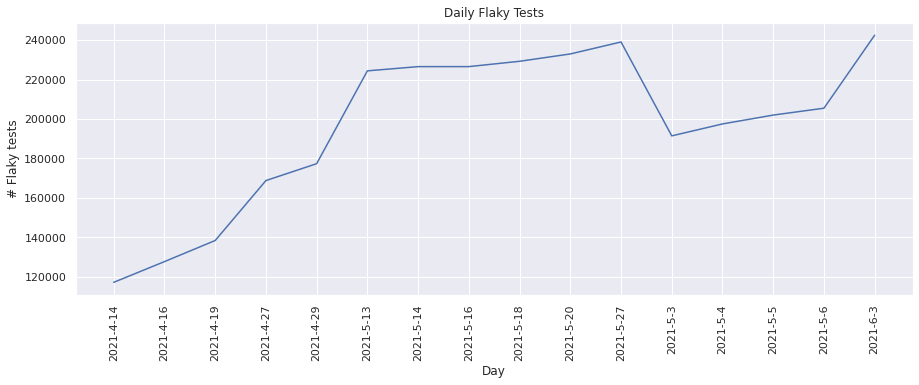

In [18]:
plot(dates, num_flakes, "Day", "# Flaky tests", "Daily Flaky Tests")

#### Flake Severity
This metric calculates the percentage of flakes by test overall. This can also be seen as a severity level or overall flake rate of test. We can visualize the change in flake severity over time.

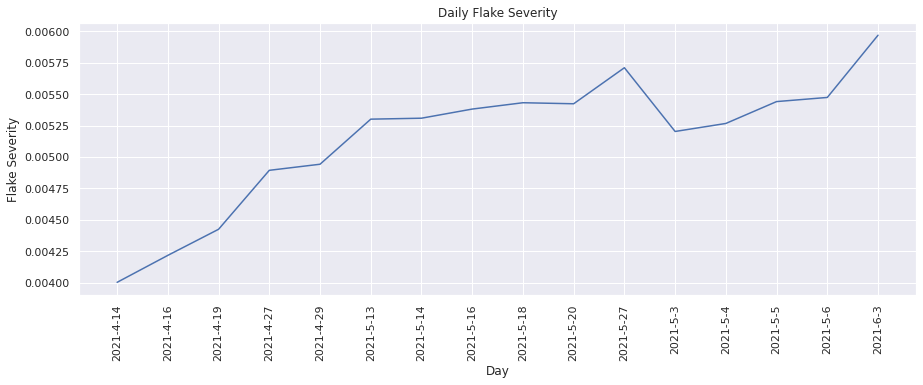

In [19]:
plot(dates, flake_severity, "Day", "Flake Severity", "Daily Flake Severity")

From the above graphs, we see that the number of flakes has increased over time and there were more "flaky" tests found.

### Percent Fixed each Timestamp
The `pct_fixed_each_ts` KPI file consists of `pct_fixed` metric file which comprises of metric data such as percentage of tests fixed. We will read each of these files and aggregate the metric values across all TestGrid dashboard, job and tests. We can then plot these aggregate metrics values.

In [20]:
pct_fixed_files = metrics_bucket.objects.filter(Prefix="metrics/pct_fixed_each_ts")

dates = []
pct_fixed_vals = []

for i in pct_fixed_files:
    # split into project key and file "path"
    project_bucket, kpifile_key = i.key.split("/", maxsplit=1)

    # read parquet
    df = cc.read_from_ceph(project_bucket, kpifile_key)

    # get x and y values to plot for this date
    pct_fixed_vals.append(
        df.pct_fixed.replace([np.inf, -np.inf], np.nan).mean(),
    )
    dates.append(
        kpifile_key.rsplit("/", maxsplit=1)[-1]
        .split("-", maxsplit=1)[-1]
        .split(".", maxsplit=1)[0]
    )

Let's plot the following metric for the `pct_fixed_each_ts` KPI file:

#### Percent of Tests Fixed
This metric calculates the percentage of tests that were failing in the previous run of the build, but are now passing. Lets plot the values for each day.

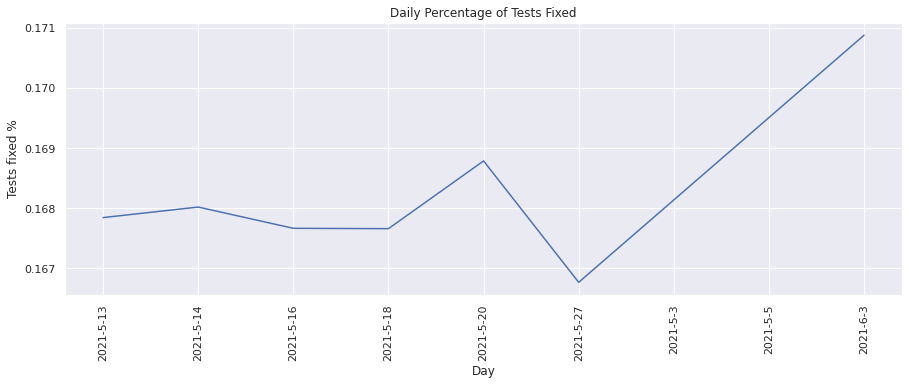

In [21]:
plot(dates, pct_fixed_vals, "Day", "Tests fixed %", "Daily Percentage of Tests Fixed")

From the above graph, we see that the percentage of tests fixed has increased over time which is a good indication of more tests passing over time.

### Persistent Failures
The `persistent_failures` KPI file consists of `consec_fail_rate`, `mean_fail_len`, `mean_time_to_fix`, `pass_to_fail_rate` and `fail_to_pass_rate` metric files. We will read each of these files and aggregate the metric values across all TestGrid dashboard, job and tests. We can then plot these aggregate metrics values.

In [22]:
persistent_failure_files = metrics_bucket.objects.filter(
    Prefix="metrics/persistent_failures"
)

dates = []
mean_length_failures = []
mean_time_to_fix = []
consecutive_failure_rate = []
pass_to_fail_rate = []
fail_to_pass_rate = []

for i in persistent_failure_files:
    # split into project key and file "path"
    project_bucket, kpifile_key = i.key.split("/", maxsplit=1)

    # read parquet
    df = cc.read_from_ceph(project_bucket, kpifile_key)

    # get x and y values to plot for this date
    mean_length_failures.append(
        df.mean_fail_len.replace([np.inf, -np.inf], np.nan).mean(),
    )
    mean_time_to_fix.append(
        df.mean_time_to_fix.replace([np.inf, -np.inf], np.nan).mean(),
    )
    consecutive_failure_rate.append(
        df.consec_fail_rate.replace([np.inf, -np.inf], np.nan).mean(),
    )
    pass_to_fail_rate.append(
        df.pass_to_fail_rate.replace([np.inf, -np.inf], np.nan).mean(),
    )
    fail_to_pass_rate.append(
        df.fail_to_pass_rate.replace([np.inf, -np.inf], np.nan).mean(),
    )
    dates.append(
        kpifile_key.rsplit("/", maxsplit=1)[-1]
        .split("-", maxsplit=1)[-1]
        .split(".", maxsplit=1)[0]
    )

Lets plot the metrics from the `persistent_failures` KPI file:

#### Mean Length of Failures
This metric helps keep track of how many times was the build (test suite) run before a failing test started to pass. Lets plot these values for each day.

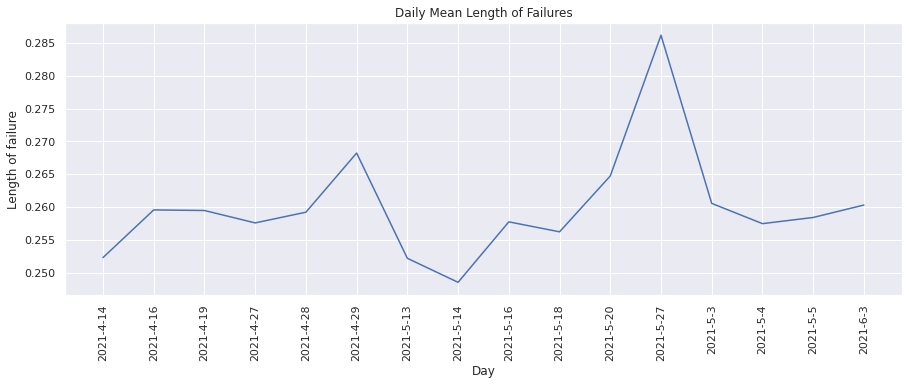

In [23]:
plot(
    dates,
    mean_length_failures,
    "Day",
    "Length of failure",
    "Daily Mean Length of Failures",
)

#### Mean Time to Fix
This metric measures how much time was taken before a failing test started to pass. Lets plot these values for each day.

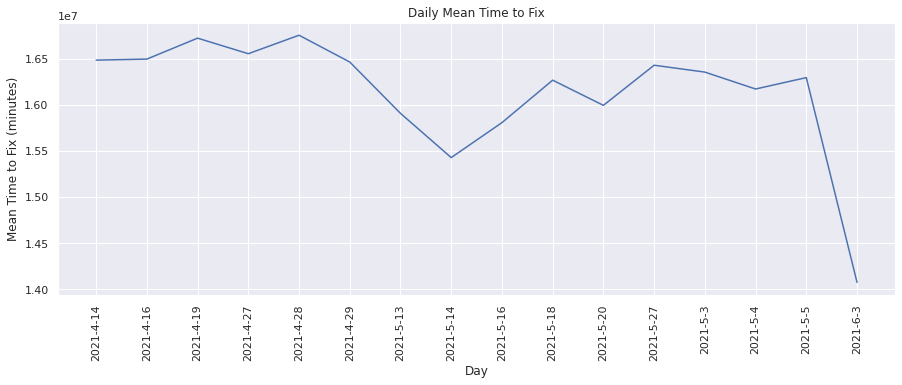

In [24]:
plot(
    dates,
    mean_time_to_fix,
    "Day",
    "Mean Time to Fix (minutes)",
    "Daily Mean Time to Fix",
)

From the above graph, we see that the mean time to fix on an average has reduced over time i.e lesser time is being taken before a failing test starts to pass.

#### Consecutive Failure Rate
This metric calculates the percentage of failing tests stay failing for more than one build. That is, what percentage of failing tests are not “one-off” failures. We can visualize the change in percentage over time.

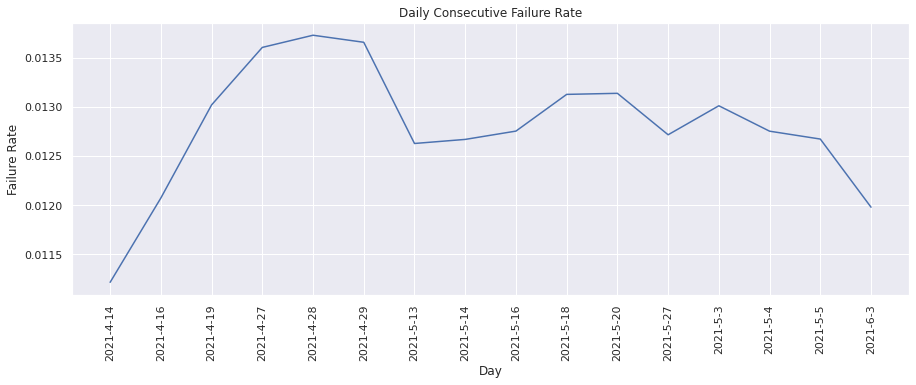

In [25]:
plot(
    dates,
    consecutive_failure_rate,
    "Day",
    "Failure Rate",
    "Daily Consecutive Failure Rate",
)

From the above graph we see that the consecutive failure rate is on an average ~0.0125. 

#### Pass to Fail Rate
This metric calculates the percentage of test runs resulted in a “pass” to “fail” transition. We can visualize the change in percentage over time.

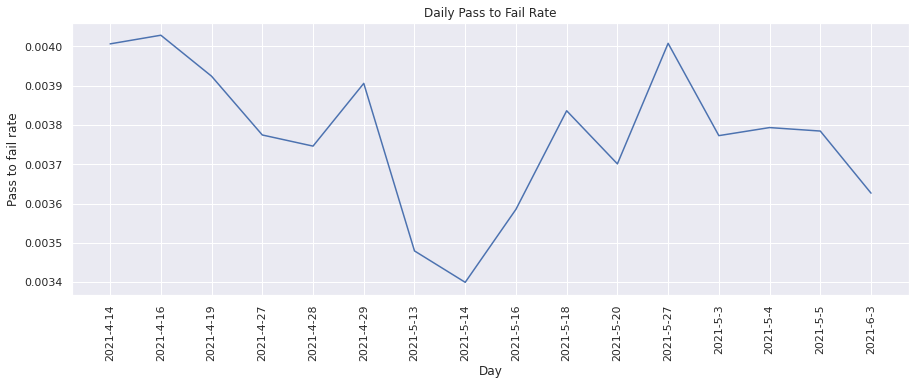

In [26]:
plot(dates, pass_to_fail_rate, "Day", "Pass to fail rate", "Daily Pass to Fail Rate")

From the above graph, we see that the pass to fail rate for tests has not been consistent.

#### Fail to Pass Rate
This metric calculates the percentage of test runs resulted in a “fail” to “pass” transition. We can visualize the change in percentage over time.

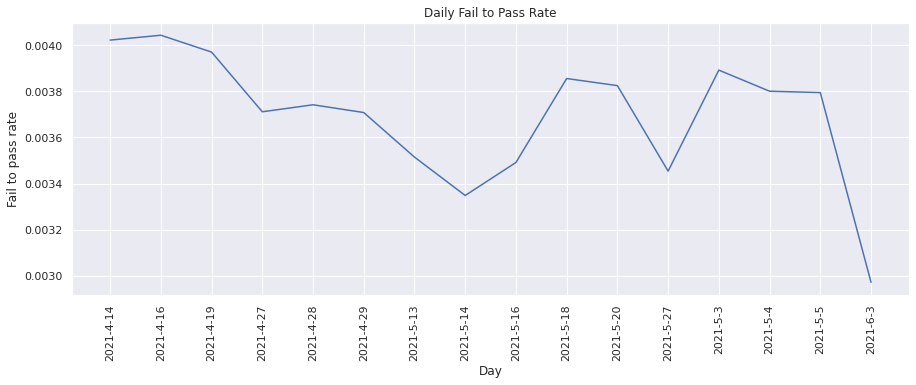

In [27]:
plot(dates, fail_to_pass_rate, "Day", "Fail to pass rate", "Daily Fail to Pass Rate")

Similary, the fail to pass rate for tests has also been inconsistent.

### Test Pass Failures
The `test_pass_failures` KPI file consists of `test_duration`, `passing` and `failing` metric files which comprise of metric data such as number of tests passing, number of failing tests etc. We will read each of these files and aggregate the metric values across all TestGrid dashboard, job and tests. We can then plot these aggregate metrics values. 

In [28]:
test_pass_failure_files = metrics_bucket.objects.filter(
    Prefix="metrics/test_pass_failures"
)

dates = []
test_pass_vals_to_plot = []
test_pass_percentage = []
test_fail_vals_to_plot = []
test_fail_percentage = []

for i in test_pass_failure_files:
    # split into project key and file "path"
    project_bucket, kpifile_key = i.key.split("/", maxsplit=1)

    # read parquet
    df = cc.read_from_ceph(project_bucket, kpifile_key)

    # get x and y values to plot for this date
    test_pass_vals_to_plot.append(
        df.passing.replace([np.inf, -np.inf], np.nan).sum(),
    )
    test_pass_percentage.append(
        (df.passing.replace([np.inf, -np.inf], np.nan).sum()) / (len(df)),
    )
    test_fail_vals_to_plot.append(
        df.failure.replace([np.inf, -np.inf], np.nan).sum(),
    )
    test_fail_percentage.append(
        (df.failure.replace([np.inf, -np.inf], np.nan).sum()) / (len(df)),
    )
    dates.append(
        kpifile_key.rsplit("/", maxsplit=1)[-1]
        .split("-", maxsplit=1)[-1]
        .split(".", maxsplit=1)[0]
    )

Lets plot the following metrics from the `test_pass_failures` KPI file:

#### Number of passing tests
This metric keeps track of the total number of test runs that passed successfully. Lets plot the values for each day.

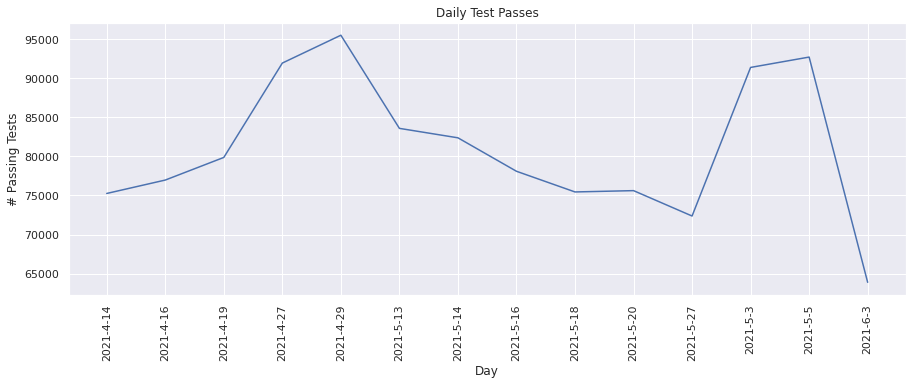

In [29]:
plot(dates, test_pass_vals_to_plot, "Day", "# Passing Tests", "Daily Test Passes")

#### Test pass percentage
This metric calculates the percentage of test runs that passed successfully. We can visualize the change in the test pass percentage over time.

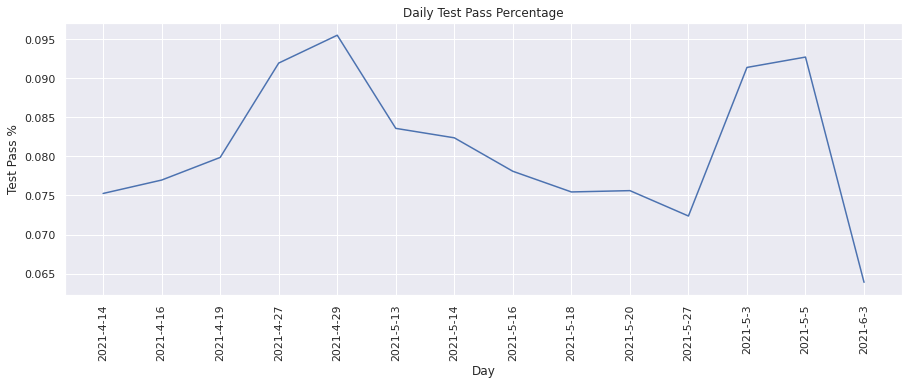

In [30]:
plot(dates, test_pass_percentage, "Day", "Test Pass %", "Daily Test Pass Percentage")

#### Number of failing tests
This metric keeps track of the total number of test runs that failed. Lets plot the values for each day.

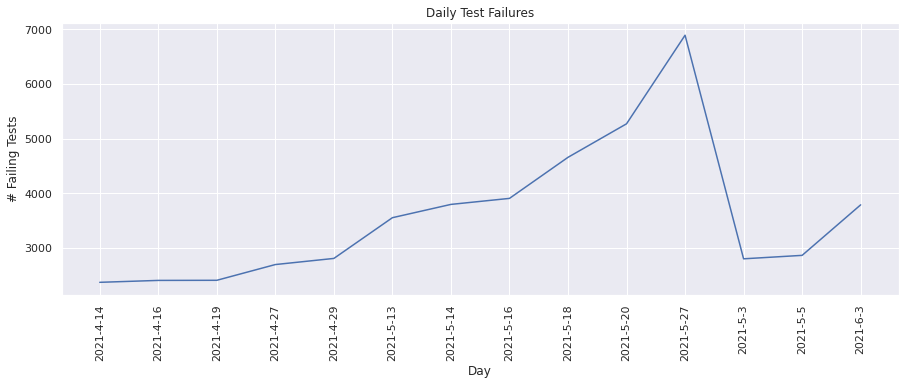

In [31]:
plot(dates, test_fail_vals_to_plot, "Day", "# Failing Tests", "Daily Test Failures")

#### Test failure percentage
This metric calculates the percentage of test runs that failed. We can visualize the change in the test failure percentage over time.

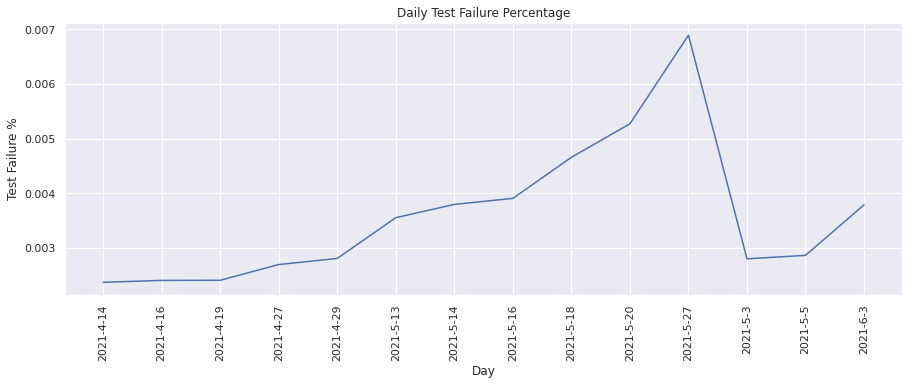

In [32]:
plot(
    dates,
    test_fail_percentage,
    "Day",
    "Test Failure %",
    "Daily Test Failure Percentage",
)

From the above graphs, we see that overall there has been an increase in the number of tests failing daily, however this increase is low i.e ~3000-7000 compared to the number of tests passing daily i.e. ~70000-95000.

### Time to Test
The `time_to_test` KPI file consists of the `test_duration` metric file which comprises of metric data such as test run times. We will read each of these files and aggregate the metric values across all TestGrid dashboard, job and tests. We can then plot these aggregate metrics values.

In [33]:
time_to_test_files = metrics_bucket.objects.filter(Prefix="metrics/time_to_test")

dates = []
avg_test_duration = []

for i in time_to_test_files:
    # split into project key and file "path"
    project_bucket, kpifile_key = i.key.split("/", maxsplit=1)

    # read parquet
    df = cc.read_from_ceph(project_bucket, kpifile_key)

    # get x and y values to plot for this date
    avg_test_duration.append(
        df.test_duration.replace([np.inf, -np.inf], np.nan).mean(),
    )
    dates.append(
        kpifile_key.rsplit("/", maxsplit=1)[-1]
        .split("-", maxsplit=1)[-1]
        .split(".", maxsplit=1)[0]
    )

Let's plot the following metric from the `time_to_test` KPI file:

#### Average Time to Test
This metric calculates the average time taken to run builds. We can visualize the change in the average time taken over time.

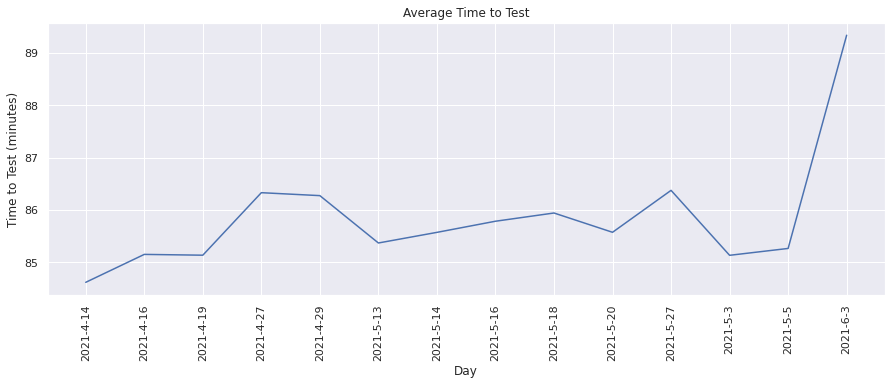

In [34]:
plot(dates, avg_test_duration, "Day", "Time to Test (minutes)", "Average Time to Test")

From the above graph, we see that the average test duration has slightly increased over time and been in the range of ~85-89 minutes.

## Conclusion
In this notebook, we have tried to read the collected metrics from ceph and use visualization libraries like `seaborn` to explore our data. We have aggregated the metric values across all TestGrid dashboards, grids and tests and plotted time series graphs to visualize the change in the metric values over time. This provides us an initial understanding of the KPI metrics at the TestGrid platform level and we can further create in-depth visualizations for each of the individual KPI metrics. 

For future work, we could look into exploring more visualization tools for further detailed analyses. 